Dataset Link : https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/YouTube_DataSet_Annotated.zip

/content/drive/MyDrive/YouTube_DataSet_Annotated.zip


In [ ]:
!mkdir -p /content/drive/MyDrive/YouTube_DataSet_Annotated/

In [ ]:
!unzip "/content/drive/MyDrive/YouTube_DataSet_Annotated.zip" -d "/content/drive/MyDrive/YouTube_DataSet_Annotated/"

Archive:  /content/drive/MyDrive/YouTube_DataSet_Annotated.zip
   creating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/
   creating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/
   creating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/Annotation/
  inflating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/Annotation/v_shooting_01_01.xgtf  
  inflating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/Annotation/v_shooting_01_02.xgtf  
  inflating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/Annotation/v_shooting_01_03.xgtf  
  inflating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/Annotation/v_shooting_01_04.xgtf  
  inflating: /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/Annotation/v_shooting_01_05.xgtf  

In [ ]:
!rm /content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/readme.txt

### New Working

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder

# Augmented transform
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Feature extractor
resnet = models.resnet18(pretrained=True).cuda().eval()
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:-1])

# Your dataset
root_dir = "/content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio"
class_names = [
    "basketball", "biking", "diving", "golf_swing", "horse_riding",
    "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping",
    "volleyball_spiking", "walking"
]

samples = []
for label in class_names:
    label_dir = os.path.join(root_dir, label)
    for sub_dir in os.listdir(label_dir):
        if sub_dir.lower() == 'annotation':
            continue
        video_dir = os.path.join(label_dir, sub_dir)
        for video in os.listdir(video_dir):
            if not video.endswith(".avi"):
                continue
            cap = cv2.VideoCapture(os.path.join(video_dir, video))
            total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_idxs = np.linspace(0, total - 1, 15).astype(int)
            frames = []
            for idx in frame_idxs:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = train_transform(frame).unsqueeze(0).cuda()
                with torch.no_grad():
                    feat = resnet_feat(frame)
                feat = torch.flatten(feat, 1).squeeze(0)
                frames.append(feat.cpu())
            cap.release()
            if len(frames) == 15:
                features = torch.stack(frames).numpy()
                samples.append((features, label))

# Encode labels
features, labels = zip(*samples)
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Save
train_features = np.array(features)
train_labels = np.array(encoded_labels)
np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_labels)
np.save("label_classes.npy", le.classes_)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 001 | Train Loss: 2.1465, Acc: 50.04% | Test Loss: 1.9153, Acc: 67.50%
Epoch 002 | Train Loss: 1.8557, Acc: 75.37% | Test Loss: 1.7310, Acc: 84.69%
Epoch 003 | Train Loss: 1.7160, Acc: 87.41% | Test Loss: 1.6848, Acc: 87.50%
Epoch 004 | Train Loss: 1.6407, Acc: 93.82% | Test Loss: 1.6375, Acc: 92.81%
Epoch 005 | Train Loss: 1.6143, Acc: 95.23% | Test Loss: 1.6085, Acc: 93.75%
Epoch 006 | Train Loss: 1.5993, Acc: 95.86% | Test Loss: 1.5926, Acc: 95.94%
Epoch 007 | Train Loss: 1.5888, Acc: 96.48% | Test Loss: 1.5948, Acc: 95.62%
Epoch 008 | Train Loss: 1.5824, Acc: 96.79% | Test Loss: 1.5936, Acc: 95.94%
Epoch 009 | Train Loss: 1.5980, Acc: 95.39% | Test Loss: 1.5832, Acc: 96.25%
Epoch 010 | Train Loss: 1.5804, Acc: 96.72% | Test Loss: 1.5901, Acc: 95.94%
Epoch 011 | Train Loss: 1.5698, Acc: 97.81% | Test Loss: 1.6453, Acc: 90.94%
Epoch 012 | Train Loss: 1.5798, Acc: 96.95% | Test Loss: 1.5885, Acc: 95.94%
Epoch 013 | Train Loss: 1.5803, Acc: 96.87% | Test Loss: 1.5805, Acc: 96.25%

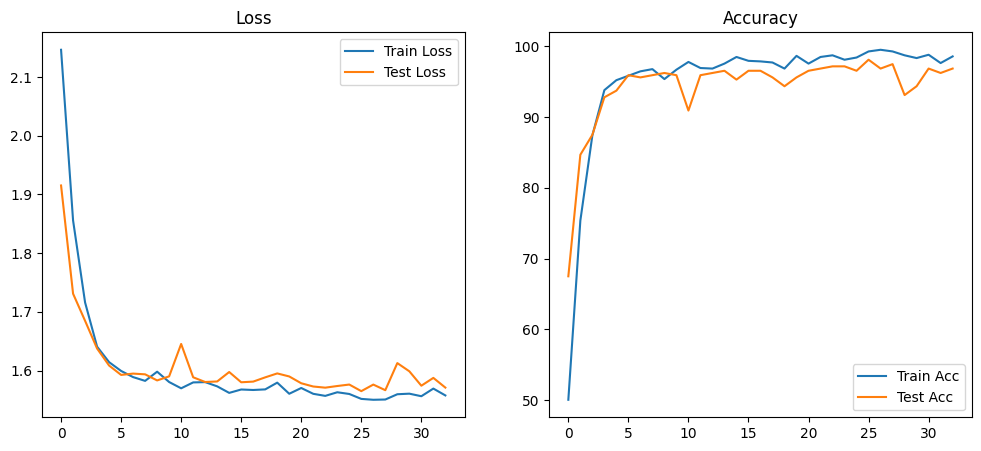

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# BiLSTM with dropout
class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return nn.functional.softmax(out, dim=1)

# Load features
train_features = torch.from_numpy(np.load('train_features.npy')).float()
train_labels = torch.from_numpy(np.load('train_labels.npy'))
idx = np.random.permutation(len(train_features))
train_features, train_labels = train_features[idx], train_labels[idx]

# Split test set
split = int(0.8 * len(train_features))
test_features = train_features[split:]
test_labels = train_labels[split:]
train_features = train_features[:split]
train_labels = train_labels[:split]

# Model
input_size = train_features.shape[-1]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(train_labels))
model = MultiLayerBiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).cuda()

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Training
num_epochs = 100
early_stop_patience = 7
train_losses, test_losses = [], []
train_accs, test_accs = [], []
best_test_loss = float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    loss_total, correct, total = 0, 0, 0
    for i in range(len(train_features)):
        x = train_features[i].unsqueeze(0).cuda()
        y = train_labels[i].unsqueeze(0).cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        pred = torch.argmax(output, 1)
        correct += (pred == y).sum().item()
        total += 1
    train_losses.append(loss_total / total)
    train_accs.append(100 * correct / total)

    # Validation
    model.eval()
    with torch.no_grad():
        loss_total, correct, total = 0, 0, 0
        for i in range(len(test_features)):
            x = test_features[i].unsqueeze(0).cuda()
            y = test_labels[i].unsqueeze(0).cuda()
            output = model(x)
            loss = criterion(output, y)
            loss_total += loss.item()
            pred = torch.argmax(output, 1)
            correct += (pred == y).sum().item()
            total += 1
    val_loss = loss_total / total
    val_acc = 100 * correct / total
    test_losses.append(val_loss)
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.2f}% | Test Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_test_loss:
        best_test_loss = val_loss
        torch.save(model.state_dict(), 'best_model_weights.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("⏹️ Early stopping triggered.")
            break

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
!cp -f best_model_weights.pth /content/drive/MyDrive/

In [ ]:
!ls /content/drive/MyDrive/best_model_weights.pth

/content/drive/MyDrive/best_model_weights.pth


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2

# ----- Class Mapping -----
action_classes = {
    0: "basketball", 1: "biking", 2: "diving", 3: "golf_swing", 4: "horse_riding",
    5: "soccer_juggling", 6: "swing", 7: "tennis_swing", 8: "trampoline_jumping",
    9: "volleyball_spiking", 10: "walking"
}

# ----- Model Definition -----
class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return torch.nn.functional.softmax(out, dim=1)

# ----- Load Model -----
input_size = 512
hidden_size = 128
num_layers = 2
num_classes = len(action_classes)
model = MultiLayerBiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).cuda()
model.load_state_dict(torch.load("best_model_weights.pth"))
model.eval()

# ----- ResNet Feature Extractor -----
resnet = models.resnet18(pretrained=True).cuda().eval()
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:-1])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- Sliding Window Prediction -----
def sliding_window_predictions(video_path, num_frames=15, stride=5):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    predictions = []

    for start in range(0, total_frames - num_frames + 1, stride):
        frames = []
        for i in range(start, start + num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame).unsqueeze(0).cuda()
            with torch.no_grad():
                feat = resnet_feat(frame)
            feat = torch.flatten(feat, 1)
            frames.append(feat.squeeze(0))

        if len(frames) == num_frames:
            input_seq = torch.stack(frames).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(input_seq)
            predictions.append(output.cpu().numpy())

    cap.release()

    if predictions:
        avg_prediction = np.mean(predictions, axis=0)[0]
        predicted_index = np.argmax(avg_prediction)
        return predicted_index, avg_prediction
    else:
        print(" Not enough valid frame sequences.")
        return None, None

# ----- Run on a Single Video -----
video_path = "/content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/v_shooting_01/v_shooting_01_01.avi"
predicted_class, softmax_scores = sliding_window_predictions(video_path)

if predicted_class is not None:
    print(f"\n Predicted Action: {action_classes[predicted_class]} ({predicted_class})")
    print("\n Confidence Scores:")
    for i, score in enumerate(softmax_scores):
        print(f"{action_classes[i]}: {score:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Predicted Action: basketball (0)

 Confidence Scores:
basketball: 0.9982
biking: 0.0001
diving: 0.0001
golf_swing: 0.0000
horse_riding: 0.0000
soccer_juggling: 0.0001
swing: 0.0000
tennis_swing: 0.0001
trampoline_jumping: 0.0000
volleyball_spiking: 0.0014
walking: 0.0000


In [ ]:
video_path = "/content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/basketball/v_shooting_01/v_shooting_01_01.avi"
#video_path = '/content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/walking/v_walk_dog_18/v_walk_dog_18_03.avi'
#video_path = '/content/drive/MyDrive/YouTube_DataSet_Annotated/action_youtube_naudio/volleyball_spiking/v_spiking_13/v_spiking_13_07.avi'
predicted_class, softmax_scores = sliding_window_predictions(video_path)

if predicted_class is not None:
    print(f"\n Predicted Action: {action_classes[predicted_class]} ({predicted_class})")
    print("\n Confidence Scores:")
    for i, score in enumerate(softmax_scores):
        print(f"{action_classes[i]}: {score:.4f}")


 Predicted Action: basketball (0)

 Confidence Scores:
basketball: 0.9982
biking: 0.0001
diving: 0.0001
golf_swing: 0.0000
horse_riding: 0.0000
soccer_juggling: 0.0001
swing: 0.0000
tennis_swing: 0.0001
trampoline_jumping: 0.0000
volleyball_spiking: 0.0014
walking: 0.0000


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


UI

In [ ]:
import streamlit as st
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import tempfile
import os

# ----- Class Mapping -----
action_classes = {
    0: "basketball", 1: "biking", 2: "diving", 3: "golf_swing", 4: "horse_riding",
    5: "soccer_juggling", 6: "swing", 7: "tennis_swing", 8: "trampoline_jumping",
    9: "volleyball_spiking", 10: "walking"
}

# ----- Model Definition -----
class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return torch.nn.functional.softmax(out, dim=1)

# ----- Load Model -----
input_size = 512
hidden_size = 128
num_layers = 2
num_classes = len(action_classes)
model = MultiLayerBiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).cuda()
model.load_state_dict(torch.load("best_model_weights.pth"))
model.eval()

# ----- ResNet Feature Extractor -----
resnet = models.resnet18(pretrained=True).cuda().eval()
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:-1])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- Prediction Function -----
def sliding_window_predictions(video_path, num_frames=15, stride=5):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    predictions = []

    for start in range(0, total_frames - num_frames + 1, stride):
        frames = []
        for i in range(start, start + num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame).unsqueeze(0).cuda()
            with torch.no_grad():
                feat = resnet_feat(frame)
            feat = torch.flatten(feat, 1)
            frames.append(feat.squeeze(0))

        if len(frames) == num_frames:
            input_seq = torch.stack(frames).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(input_seq)
            predictions.append(output.cpu().numpy())

    cap.release()

    if predictions:
        avg_prediction = np.mean(predictions, axis=0)[0]
        predicted_index = np.argmax(avg_prediction)
        return predicted_index, avg_prediction
    else:
        return None, None

# ----- Streamlit UI -----
st.set_page_config(page_title="Action Recognition", layout="centered")
st.title(" Action Recognition with BiLSTM")

uploaded_file = st.file_uploader("Upload a video (.avi)", type=["avi"])

if uploaded_file:
    st.video(uploaded_file)

    # Save temp video
    with tempfile.NamedTemporaryFile(delete=False, suffix=".avi") as tmp:
        tmp.write(uploaded_file.read())
        temp_video_path = tmp.name

    st.info("Processing video... Please wait.")

    predicted_class, scores = sliding_window_predictions(temp_video_path)

    if predicted_class is not None:
        st.success(f" **Predicted Action**: {action_classes[predicted_class]}")
        st.subheader(" Confidence Scores:")
        for i, score in enumerate(scores):
            st.write(f"**{action_classes[i]}**: {score:.4f}")
    else:
        st.error("Not enough valid frames to make a prediction.")

    os.remove(temp_video_path)

2025-04-04 01:29:19.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.394 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.397 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 01:29:19.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.151.31:8501

  Stopping...
